# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Данные геологоразведки трёх регионов находятся в файлах:

    geo_data_0.csv
    geo_data_1.csv
    geo_data_2.csv
    
- *id* — уникальный идентификатор скважины;
- *f0, f1, f2* — три признака точек;
- *product* — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
import pandas as pd
from numpy.random import RandomState
from IPython.display import display
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Загрузка и подготовка данных

Загрузим данные и посмотрим на них.

In [2]:
nregions = 3 #Количество регионов
geo_data = []

for i in range(nregions):
    print('geo_data_{}:'.format(i))
    print()
    geo_data.append(pd.read_csv('datasets/geo_data_' + str(i) + '.csv'))
    print(geo_data[i].info())
    display(geo_data[i].sample(n=5, random_state=42))
    print()

geo_data_0:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
75721,7C6bA,0.599283,-0.557623,2.121187,122.073350
80184,dVxsn,0.739017,-0.463156,-1.347584,48.738540
19864,1Gm3l,1.422743,-0.534917,3.718798,131.338088
76699,Nzg1t,1.580244,-0.238458,2.805149,88.327757
92991,Z7b4F,0.918974,0.023961,2.598575,36.959266



geo_data_1:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
75721,fYVDK,6.078076,0.084568,0.002957,0.000000
80184,3SQcq,16.462386,2.712946,1.993030,53.906522
19864,hQ1gJ,7.051898,0.766983,4.990194,134.766305
76699,Y4vux,-0.240045,-0.380804,3.999693,107.813044
92991,H1NUw,13.350111,-8.558281,0.002010,0.000000



geo_data_2:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


,id,f0,f1,f2,product
75721,sPjbT,2.111118,-1.679773,3.112240,117.441301
80184,1u4uo,0.734759,0.747788,3.670879,47.841249
19864,kZ6HO,-2.513109,0.844631,-4.922889,45.883483
76699,gCZGK,-2.035301,-1.522988,5.072839,139.014608
92991,rqJHx,2.744145,1.429952,-1.372661,84.004276


Пропущенных значений в таблицах нет, типы данных соответствуют значениям столбцов.

Целевым признаком является product. Признак id однозначно определяет скважину, но не подходит для прогнозирования объёмов нефти. Для модели необходимые признаки - это f0, f1 и f2. Посмотрим на значения числовых столбцов таблиц и на корреляцию признаков f0, f1 и f2 между собой: если они коррелируют, то для обучения модели один из таких признаков нужно будет не учитывать.

In [3]:
features_name = ['f0','f1','f2']

for i in range(nregions):
    display(geo_data[i].describe()
            .applymap(lambda x: '{:.2f}'.format(x) if x != 100000 else x)
            .style.set_caption('geo_data_{}'.format(i))
           )
    display(geo_data[i][features_name].corr()
            .applymap(lambda x: '{:.3f}'.format(x) if x != 1 else x)
            .style.set_caption('Матрица корреляций признаков geo_data_{}'.format(i))
           )
    print()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.50,0.25,2.50,92.50
std,0.87,0.50,3.25,44.29
min,-1.41,-0.85,-12.09,0.00
25%,-0.07,-0.20,0.29,56.50
50%,0.50,0.25,2.52,91.85
75%,1.07,0.70,4.72,128.56
max,2.36,1.34,16.00,185.36


,f0,f1,f2
f0,1.000000,-0.441,-0.003
f1,-0.441,1.000000,0.002
f2,-0.003,0.002,1.000000


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.14,-4.80,2.49,68.83
std,8.97,5.12,1.70,45.94
min,-31.61,-26.36,-0.02,0.00
25%,-6.30,-8.27,1.00,26.95
50%,1.15,-4.81,2.01,57.09
75%,8.62,-1.33,4.00,107.81
max,29.42,18.73,5.02,137.95


,f0,f1,f2
f0,1.000000,0.182,-0.002
f1,0.182,1.000000,-0.003
f2,-0.002,-0.003,1.000000


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.00,-0.00,2.50,95.00
std,1.73,1.73,3.47,44.75
min,-8.76,-7.08,-11.97,0.00
25%,-1.16,-1.17,0.13,59.45
50%,0.01,-0.01,2.48,94.93
75%,1.16,1.16,4.86,130.60
max,7.24,7.84,16.74,190.03


,f0,f1,f2
f0,1.000000,0.001,-0.000
f1,0.001,1.000000,0.001
f2,-0.000,0.001,1.000000


Самая большая корреляция наблюдается у признаков f0 и f1 в регионе 0: 0,44 - но это недостаточно много, чтобы можно было исключить из рассмотрения один из признаков. Остальные признаки не коррелируют между собой.

Значения признаков находятся в разных диапазонах, поэтому перед обучением моделей, эти признаки нужно отмасштабировать. Средние значения близки к медиане. Посмотрим, на сколько распределения значений признаков отличаются от нормального.

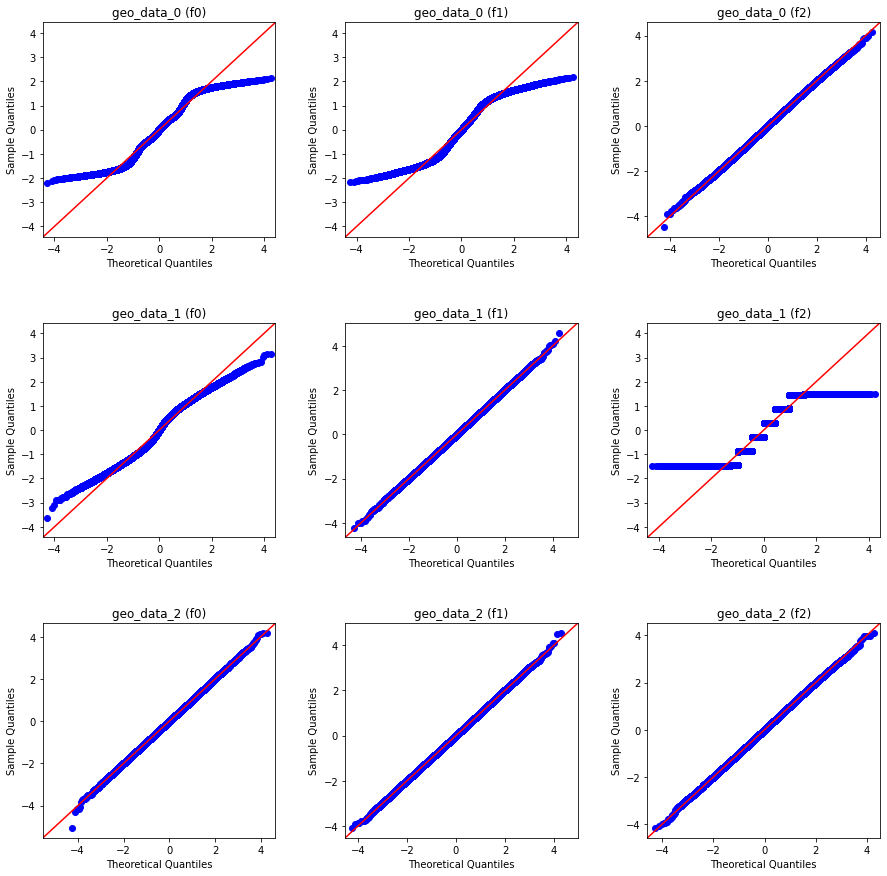

In [4]:
f, ax = plt.subplots(nregions, len(features_name), gridspec_kw={'hspace': 0.4, 'wspace': 0.3})
f.set_figheight(15)
f.set_figwidth(15)

for i in range(nregions):
    for j, column_name in enumerate(features_name):
        sm.qqplot(geo_data[i][column_name], line='45', fit=True, ax=ax[i, j])
        ax[i, j].set_title('geo_data_' + str(i) + ' (' + column_name + ')')

Некоторые признаки отклоняются от нормального распределения на больших и маленьких значениях, но в целом их можно принять как нормальные и использовать scaler. 

Сохраним признаки и целевой признак в отдельные таблицы.

In [5]:
features = []
target = []

for i in range(nregions):
    features.append(geo_data[i][features_name])
    target.append(geo_data[i]['product'])
    print('Размер таблицы с признаками для региона {}: {}'.format(i, features[i].shape))
    print('Размер столбца с целевым признаком для региона {}: {}'.format(i, target[i].shape))
    print()

Размер таблицы с признаками для региона 0: (100000, 3)
Размер столбца с целевым признаком для региона 0: (100000,)

Размер таблицы с признаками для региона 1: (100000, 3)
Размер столбца с целевым признаком для региона 1: (100000,)

Размер таблицы с признаками для региона 2: (100000, 3)
Размер столбца с целевым признаком для региона 2: (100000,)



Разделим данные на обучающую и валидационную выборки в соотношении 75:25 для каждого региона.

In [6]:
features_train = []
features_valid = []
target_train = []
target_valid = []

for i in range(nregions):
    x_train, x_valid, y_train, y_valid = train_test_split(
        features[i], target[i], test_size=0.25, random_state=42)
    features_train.append(x_train)
    features_valid.append(x_valid)
    target_train.append(y_train)
    target_valid.append(y_valid)
    print('Рамер обучающей выборки для региона {}:'.format(i), features_train[i].shape, target_train[i].shape)
    print('Рамер валидационной выборки для региона {}:'.format(i), features_valid[i].shape, target_valid[i].shape)
    print()

Рамер обучающей выборки для региона 0: (75000, 3) (75000,)
Рамер валидационной выборки для региона 0: (25000, 3) (25000,)

Рамер обучающей выборки для региона 1: (75000, 3) (75000,)
Рамер валидационной выборки для региона 1: (25000, 3) (25000,)

Рамер обучающей выборки для региона 2: (75000, 3) (75000,)
Рамер валидационной выборки для региона 2: (25000, 3) (25000,)



Отмасштабируем признаки.

In [7]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()

for i in range(nregions):
    scaler.fit(features_train[i][features_name])
    features_train[i][features_name] = scaler.transform(features_train[i][features_name])
    features_valid[i][features_name] = scaler.transform(features_valid[i][features_name])
    display(features_train[i].describe()
            .applymap(lambda x: '{:.2f}'.format(x) if x != 75000 else x)
            .style.set_caption('geo_data_{}'.format(i))
           )
    print()

,f0,f1,f2
count,75000.000000,75000.000000,75000.000000
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.19,-2.18,-3.89
25%,-0.66,-0.89,-0.68
50%,0.00,0.00,0.00
75%,0.65,0.89,0.68
max,2.14,2.15,4.15


,f0,f1,f2
count,75000.000000,75000.000000,75000.000000
mean,-0.00,0.00,0.00
std,1.00,1.00,1.00
min,-3.65,-4.21,-1.48
25%,-0.83,-0.68,-0.88
50%,0.00,-0.00,-0.28
75%,0.83,0.68,0.88
max,3.16,4.21,1.48


,f0,f1,f2
count,75000.000000,75000.000000,75000.000000
mean,0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-5.06,-4.09,-4.16
25%,-0.67,-0.68,-0.68
50%,0.00,-0.00,-0.00
75%,0.67,0.67,0.68
max,4.18,4.53,4.10


**Вывод**

Для каждого региона были загружены и изучены данные о 100000 скважин. Признаки и целевой признак выделены в отдельные таблицы. Данные разделены на обучающую и валидационную выборки в соотношении 75:25. Признаки отмасштабированы.

## Обучение и проверка модели

Для каждого региона создадим и обучим на обучающей выборке модель линейной регрессии. С помощью модели найдём предсказанные значения целевого признака на валидационной выборке и сохраним среднее предсказанное значение объёма нефти для скважины в регионе. Для оценки качества модели посчитаем RMSE, используя предсказанные значения и известные реальные значения целевого признака, и сравним со значением RMSE для модели, которая для всех значений признаков предсказывала бы одно значение - среднее в обучающей выборке.

In [8]:
model = []
predictions_valid = []
predictions_info = []

for i in range(nregions):
    model.append(LinearRegression())
    model[i].fit(features_train[i], target_train[i])
    predictions_valid.append(pd.Series(model[i].predict(features_valid[i]), index=target_valid[i].index))
    
    rmse = mean_squared_error(target_valid[i], predictions_valid[i]) ** 0.5
    rmse_mean_pred = mean_squared_error(
        target_valid[i], pd.Series(target_train[i].mean(), index=target_valid[i].index)) ** 0.5
    
    predictions_info.append([i, predictions_valid[i].mean(), rmse, rmse_mean_pred])
    
predictions_info = pd.DataFrame(
    predictions_info, 
    columns = ['region', 'predictions_mean', 'RMSE', 'RMSE_const_model']).set_index('region')

round(predictions_info, 2)

,predictions_mean,RMSE,RMSE_const_model
region,,,
0,92.40,37.76,44.28
1,68.71,0.89,45.94
2,94.77,40.15,44.78


Все получившиеся модели дают предсказание лучше, чем модель, предсказывающая всегда одно и то же число. Наилучшее качество предсказаний в регионе 1, но средний предсказанный объём нефти в этом регионе наименьший.

**Вывод**

Для каждого региона создана модель линейной регрессии и обучена на обучающей выборке. На валидационной выборке сделаны предсказания целевого признака и посчитано среднее значение. Для оценки качества модели посчитано значение RMSE. Также RMSE посчитано для модели, которая всегда предсказывает одно и то же число - среднее на обучающей выборке. 

Все модели показали себя лучше, чем константная модель. Наиболее точные результаты предсказаны в регионе 1. По среднему значению объёма нефти лидирует регион 2, затем следует регион 0 - с небольшим отставанием, а регион 1 показывает существенно более низкие результаты.

## Подготовка к расчёту прибыли

Сохраним ключевые параметры из условия задачи.

In [9]:
number_of_all_welss = 500 #Исследуют 500 точек
number_of_best_wells = 200 #Бурят 200 лучших
budget = 10 ** 10 #Бюджет на разработку скважин - 10 млрд.р.
unit_cost = 450000 #Доход с 1 тыс. баррелей в рублях
max_loss_prob = 0.025 #Максимально допустимая вероятность убытка для региона

Рассчитаем, какой объём нефти необходимо добывать с каждой скважины в регионе, чтобы разработка была безубыточной. Разделим стоимость разработки в регионе на количество скважин, которые будут бурить, - так мы получим стоимость одной скважины. Стоимость скважины разделим на доход с 1 тыс. баррелей, чтобы узнать объём нефти, который покроет расходы.

In [10]:
breakeven_volume = budget / number_of_best_wells / unit_cost
print('Средний объём нефти со скважины в регионе для безубыточности: {:.2f} тыс. баррелей.'.format(breakeven_volume))

Средний объём нефти со скважины в регионе для безубыточности: 111.11 тыс. баррелей.


Чтобы выйти на точку безубыточности, каждая из 200 скважин в регионе должна принести 111,11 тыс. баррелей нефти. Это больше, чем средний предсказанный объём скважины в любом из трёх регионов. Т.е. недостаточно пробурить случайные 200 скважин, чтобы оправдать расходы. 

Возможно, если взять для расчёта лучшие скважины, картина изменится. Посчитаем реальную прибыль по лучщим предсказанным скважинам.

In [11]:
def profit(target, predictions, number_of_wells):
    return (target[predictions.sort_values(ascending=False).index][:number_of_wells] * unit_cost).sum() - budget

for i in range(nregions):
    print('Прибыль с двухсот лучших предсказанных скважин региона {}: {:.2f} млрд.р.'.format(
        i,
        profit(target_valid[i], predictions_valid[i], number_of_best_wells) / 10 ** 9
    ))

Прибыль с двухсот лучших предсказанных скважин региона 0: 3.36 млрд.р.
Прибыль с двухсот лучших предсказанных скважин региона 1: 2.42 млрд.р.
Прибыль с двухсот лучших предсказанных скважин региона 2: 2.60 млрд.р.


**Вывод**

Для безубыточной разработки 200 скважин в регионе каждая должна приносить 111.11 тыс. баррелей. В представленных регионах недостаточно нефти, чтобы можно было пробурить 200 случайных скважин и получать прибыль. Если выбрать для бурения 200 лучших предсказанных скавжин, то суммарная выручка с продажи добытой нефти покроет затраты на разработку, при этом наибольшую прибыль принесёт регион 0.

## Расчёт прибыли и рисков 

При разведке региона изучают только 500 скважин. Выясним, достаточно ли этого, чтобы найти 200 доходных скважин. Возьмём 1000 выборок по 500 скважин и посмотрим на распределение прибыли.

In [12]:
bootstrap_samples = 1000
state = RandomState(42)
profit_values = []
profit_info = []

for i in range(nregions):
    profit_values.append([])
    
    for _ in range(bootstrap_samples):
        sample = predictions_valid[i].sample(n = number_of_all_welss, random_state = state, replace = True)
        profit_values[i].append(profit(target_valid[i][sample.index], sample, number_of_best_wells))
        
    profit_values[i] = pd.Series(profit_values[i])
    mean_profit = profit_values[i].mean()
    lower_profit = profit_values[i].quantile(0.025)
    upper_profit = profit_values[i].quantile(0.975)
    loss_prob = profit_values[i][profit_values[i] < 0].count() / profit_values[i].count()
    profit_info.append([i, mean_profit, lower_profit, upper_profit, loss_prob, max_loss_prob])
    
profit_info = pd.DataFrame(
    profit_info,
    columns = ['region', 'mean_profit', 'lower_profit', 'upper_profit', 'loss_prob', 'max_loss_prob']
).set_index('region')

profit_info.applymap(lambda x: '{:.2f} млн.р.'.format(x / 10 ** 6) if abs(x) > 1 else '{:.1%}'.format(x))

,mean_profit,lower_profit,upper_profit,loss_prob,max_loss_prob
region,,,,,
0,427.85 млн.р.,-97.25 млн.р.,954.22 млн.р.,5.5%,2.5%
1,511.53 млн.р.,91.70 млн.р.,921.46 млн.р.,0.6%,2.5%
2,408.55 млн.р.,-120.62 млн.р.,960.86 млн.р.,7.5%,2.5%


**Вывод**

Чтобы определить распределение прибыли, в каждом регионе проанализированы 1000 случайных выборок по 500 скважин. Посчитаны средние значения ожидаемой прибыли и 95%-ый доверительный интервал. Также посчитана вероятность убытка. Только в одном регионе - регионе 1 - вероятность убытка меньше порогового значения 2,5%. В этом же регионе в 95%-ый интервал значений прибыли не входят отрицательные величины. В двух других регионах вероятность убытка достаточно высокая, при этом максимально возможная прибыль сопостовима с максимально возможной прибылью в регионе 1.

## Вывод

Для каждого региона загружены и проанализированы данные о нефтяных месторождениях. Признаки и целевой признак сохранены в соответствующие таблицы. Данные разделены на обучающую и валидационную выборки в соотношении 75:25, признаки отмасштабированы. Модель линейной регрессии обучена на обучающей выборке. С помощью модели получены предсказания для валидационной выборки и посчитано среднее значение объёма нефти. Качество модели оценено с помощью RMSE в сравнении с константной моделью. Также посчитан объём нефти, необходимый для безубыточной разработки.

Выяснилось, что средних предсказанных объёмов нефти в регионах недостаточно для безубыточного производства, однако лучшие 200 скважин дают хорошую прибыль. Чтобы оценить риски и доход, взяты 1000 случайных выборок по 500 скважин, из которых согласно предсказаниям модели выбраны 200 лучших и посчитана реальная прибыль. На основании получившейся выборки прибылей посчитано среднее значение, 95%-ый доверительный интервал и риск убытка.

Только в одном регионе - регионе 1 - риск убытка меньше 2,5%, а в 95%-ом доверительном интервале нет отрицательных значений прибыли. Среднее предсказанное значение прибыли в этом регионе больше, чем в остальных.

Для разработки месторождений нефти рекомендован регион 1.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован